<a href="https://colab.research.google.com/github/pjoyce1995/pjoyce1995/blob/main/Methane_neural_net_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting point source emissions of CH4 using a neural network

Here is the code for locating and quantifying methane (CH4) plumes using a deep neural network based on Joyce et al., 2022 (unpublished).

Steps for running this code are as follows:

**1. Download the files in the below directory and upload into an appropriate directory in your google drive:
https://drive.google.com/drive/folders/1R5tvk25flRWmrnaC-uvDsAsu92zUHkiU?usp=sharing**

**2 (optional) Upload your own PRISMA image and insert it into the same directory from (1).**

**3. Edit the directory on the 4th line of the cell below with the location of the files. If you uploaded your own PRISMA image then edit the fifth line accordingly.**

**4. Run all the cells in order and the output of the model will be plotted at the bottom.**


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

directory = '/content/gdrive/MyDrive/Colab_data/methane_inference_files/'
#file_dir = directory + 'PRS_L1_STD_OFFL_20200702065755_20200702065759_0001_output.nc'
file_dir = directory + 'prisma_turk_2_retrieved_ch4.nc' #ALTERNATIVE IMAGE WITH KNOWN PLUME
#file_dir = directory + 'prisma_4_retrieved_ch4.nc' #ALTERNATIVE IMAGE WITH KNOWN PLUME

#IMPORT MODULES
from netCDF4 import Dataset
import copy
import numpy as np
import keras.models
from google.colab import drive
from matplotlib import pyplot as plt
drive.mount('/content/gdrive')


#FUTURE ADDITIONS:
#HOST THE DRIVE FILES SOMEWHERE AND ADD A BUTTON WHERE USERS CAN UPLOAD PRISMA IMAGE(S).
#ALLOW THE MODEL TO PERFORM INFERENCE ON MANY PRISMA SCENES


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


The class below is split up into 4 sections:

1. At the beginning of the __init__ (initialise) function, we load up the PRISMA image.

2. Then we run the __preprocess__ function on the image which normalises the image so mean and standard deviations are roughly 0, 1 respectively (a requirement for deep learning).

3. Next we run the __split_up_image__ function which splits the image into 128x128 images (the dimensions of the images during training), with an overlap of 19 pixels (due to the divisibility of 872).

4. Now, using __model.predict__ we perform inference on the images using the neural network.

5. After this, the __reform_image__ function reforms the image into the 1000x1000 shape and the mask and concentrations are saved.

6. Then the __centre_plumes__ function identifies the points in the 1000x1000 masks with high probability of being a plume and groups the pixels by those having X pixels or lower distance between other pixels in the plume (default value for X is 20).

7. The __output_im_centred_plume__ takes the coordinates from __centre_plumes__ and creates new sub-images centred on the plume(s).

8. Inference is then performed on the sub-image(s) with a plume (if there are any).



In [ ]:
class predict_ch4():
    def __init__(self,file_dir,model, max_distance_plumes=20):
        self.max_distance_plumes = max_distance_plumes
        self.model = model
        file = Dataset(file_dir,'r')
        retr_meth = np.array(file['retrieved_ch4'])
        radiance = np.array(file['radiance'])
        self._preprocess(retr_meth,radiance)
        self._split_up_image()
        self.predicted=(self.model).predict(tf.convert_to_tensor(self.split_image[:,:,:,1:]))
        self._reform_image()
        self._centre_plumes()
        self._output_im_centred_plume()
    def _preprocess(self,retr_meth, radiance):
        retr_meth[retr_meth>=1e33]=np.nan
        retr_meth=(retr_meth-4.7685366e+17)/(6.308392e18) 
        retr_meth[np.isnan(retr_meth)]=np.nanmean(retr_meth)
        raw_processed = retr_meth
        raw_processed = np.expand_dims(raw_processed,2)

        means_bands=[5411.967, 5536.116, 6201.5005, 0.5425253, 0.5433834, 0.53931504, 0.53951705, 0.54865444, 0.5470869, 0.52260786, 0.4946622, 0.48093814, 0.48316777, 0.46916655, 0.46389136, 0.43893293, 0.42890018, 0.4457515, 0.4455899, 0.43492988, 0.41616684, 0.39955452, 0.37611, 0.3637046, 0.3508086, 0.33565056, 0.33047378, 0.31389207, 0.29585046, 0.30338344, 0.30330583, 0.2571094, 0.2747157, 0.2610629, 0.22502172, 0.19918877, 0.20755544, 0.2]

        std_bands=[1238.7577, 873.5337, 708.6302, 0.13850343, 0.13837896, 0.13668847, 0.13625899, 0.13787709, 0.13628249, 0.12854788, 0.12045229, 0.11635156, 0.11609654, 0.11212393, 0.11023775, 0.103803016, 0.100570686, 0.10470784, 0.1055888, 0.10370284, 0.099770874, 0.096735984, 0.092104495, 0.09006548, 0.08761533, 0.08428294, 0.08325665, 0.07940724, 0.075318284, 0.07779357, 0.07819552, 0.06611192, 0.07075988, 0.06752622, 0.058537956, 0.051994734, 0.054290853,0.05]

        band_list=range(0,37)
        for band_num in band_list:
            raw_band=copy.deepcopy(radiance[band_num,:,:])
            raw_band[raw_band>1e33]=np.nan
            raw_band[raw_band==-9999.0]=np.nan

            raw_band[np.isnan(raw_band)]=np.nanmean(raw_band)
            raw_band[np.isinf(raw_band)]=np.nanmean(raw_band)
            raw_band=(raw_band - means_bands[band_num])/(std_bands[band_num])
            raw_band=np.expand_dims(raw_band,2)

            raw_processed=np.concatenate((raw_processed, raw_band),axis=2)
        self.image = raw_processed
  
    def _split_up_image(self):
        split_image = np.zeros((81,128,128,38))
        for i in range(9):
            for j in range(9):
                split_image[i*9+j,:,:,:] = self.image[i*109:(i*109)+128, j*109:(j*109)+128,:]
        self.split_image = split_image
            
    def _reform_image(self):
        reformed_image = np.zeros((2, 1000,1000,1))
        for pred in range(2):
          for i in range(9):
              for j in range(9):
                reformed_image[pred,i*109:(i*109)+128, j*109:(j*109)+128]=self.predicted[pred][i*9+j,:,:]

        self.reformed_pred = reformed_image
    def _centre_plumes(self):
        """Function to separate the plumes and produce a vector of the coordinates of the pixels making up the plume"""
        coords_plumes = np.argwhere(self.reformed_pred[0,:,:]>0.9)
        coord_strongest_methane = np.argwhere(self.reformed_pred[1,:,:]==np.max(self.reformed_pred[1,:,:]))[0]

        coords_list_plumes=[]
        coords_list_plumes.append(self._find_continuous_plume(coord_strongest_methane, coords_plumes))
        coords_plumes_list = [tuple(j) for j in coords_plumes]

        remaining_coords_list = list(set(coords_plumes_list) - set(coords_list_plumes[-1]))

        #print(len(coords_list_plumes), len(remaining_coords_list))
        while len(remaining_coords_list)>0:
            coords_list_plumes.append(self._find_continuous_plume(remaining_coords_list[0], remaining_coords_list))
            coords_plumes_list = [tuple(j) for j in coords_plumes]
            remaining_coords_list = list(set(remaining_coords_list) - set(coords_list_plumes[-1]))
            #print(len(coords_list_plumes), len(remaining_coords_list))
        
        self.coords_vec_sep_plumes = coords_list_plumes

    def _output_im_centred_plume(self):
        """This function takes the coordinates from _centre_plumes and puts them in the centre
        then checks if there are overlaps with other plumes and adjusts. Finally it performs 
        inference with the plumes in the centre of the image"""

        centred_model_output=[]

        input_focused_plumes=np.zeros((len(self.coords_vec_sep_plumes),128,128,38))

        xmax_list,xmin_list, ymax_list, ymin_list = [], [], [], []
        for coord_set in self.coords_vec_sep_plumes:
            xmin, xmax, ymin, ymax = 1000, 0, 1000, 0
            for ind_coord in coord_set:
                if ind_coord[0]<xmin: xmin=ind_coord[0]
                if ind_coord[0]>xmax: xmax=ind_coord[0]
                if ind_coord[1]<ymin: ymin=ind_coord[1]
                if ind_coord[1]>ymax: ymax=ind_coord[1]

            added_space_x, added_space_y = 128-(xmax-xmin), 128-(ymax-ymin)
            xmax = xmax + int(added_space_x/2)
            xmin = xmin - added_space_x + int(added_space_x/2)
            ymax = ymax + int(added_space_y/2)
            ymin = ymin - added_space_y + int(added_space_y/2)

            if xmax>1000: xmax, xmin = 1000, 872
            if ymax>1000: ymax, ymin = 1000, 872
            if xmin<0: xmax, xmin = 128, 0
            if ymin<0: ymax, ymin = 128, 0

            xmax_list.append(xmax)
            xmin_list.append(xmin)
            ymax_list.append(ymax)
            ymin_list.append(ymin)
        
        #CHECK FOR OVERLAPPING PLUMES
        for iter_num in range(5):
            for k in range(len(xmax_list)):
                for l in range(len(xmax_list)):
                    if k!=l and (xmin_list[k] in range(xmin_list[l],xmax_list[l]+1) or xmax_list[k] in range(xmin_list[l],xmax_list[l]+1)) and (ymin_list[k] in range(ymin_list[l],ymax_list[l]+1) or ymax_list[k] in range(ymin_list[l],ymax_list[l]+1)):#IF THE kth AND lth PLUMES OVERLAP
                        if abs(xmin_list[l] - xmax_list[k]) > abs(ymin_list[l] - ymax_list[k]): #if difference greater in x-direction
                            if xmax_list[k] in range(xmin_list[l],xmax_list[l]+1): #if overlap ocurrs in the max_x side of current plume
                                xmax_list[k] = xmin_list[l]-1
                                xmin_list[k] = xmax_list[k]-128
                                if xmin_list[k]<0: xmax_list[k], xmin_list[k] = 128,0
                            else:
                                xmin_list[k] = xmax_list[l]+1
                                xmax_list[k] = xmin_list[k]+128
                                if xmax_list[k]>1000: xmax_list[k], xmin_list[k] = 1000,872
                        else:
                            if ymax_list[k] in range(ymin_list[l],ymax_list[l]+1): #if overlap ocurrs in the max_y side of current plume
                                ymax_list[k] = ymin_list[l]-1
                                ymin_list[k] = ymax_list[k]-128
                                if ymin_list[k]<0: ymax_list[k], ymin_list[k] = 128,0
                            else:
                                ymin_list[k] = ymax_list[l]+1
                                ymax_list[k] = ymin_list[k]+128
                                if ymax_list[k]>1000: ymax_list[k], ymin_list[k] = 1000,872


        #NOW ADD THESE INDICES TO CREATE THE PLUME SHAPES
        for k in range(len(xmax_list)):
            input_focused_plumes[k, :,:,:] = self.image[xmin_list[k]:xmax_list[k],ymin_list[k]:ymax_list[k],:]
        
        self.input_ims_focused_plumes=input_focused_plumes
        self.output_ims_focused_plumes=(self.model).predict(tf.convert_to_tensor(input_focused_plumes[:,:,:,1:]))

    def _find_continuous_plume(self, start_pixel, possible_pixels):
        #FIND ALL PIXELS THAT ARE max_distance_plumes OR FEWER PIXELS AWAY FROM CLOSEST PIXEL IN PLUME
        coords_list_plume = [tuple(start_pixel)]
        new_pixels=1
        while new_pixels>0:
            new_pixels=0
            for coord in possible_pixels:
                for coord_cur_plume in coords_list_plume:
                    if tuple(coord) not in coords_list_plume and abs(list(coord)[0]-coord_cur_plume[0])<=self.max_distance_plumes and abs(list(coord)[1]-coord_cur_plume[1])<=self.max_distance_plumes:
                        coords_list_plume.append(tuple(coord))
                        new_pixels+=1
        return coords_list_plume
      
        

Now we define the neural network model which is split into 4 parts:
1. Predicting the mask of the plume.
2. Predicting the methane concentration in the plume.
3. Predicting whether or not there is a plume in the image or not (not the same as (1)).
4. Predicting the emission rate.

At each stage of the model, the outputs from the previous stages are concatenated with the input satellite data.

In [ ]:
from keras.layers import ReLU, Conv2D,Conv1D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D, Dense, Conv1D, Flatten, Reshape,concatenate, Lambda
from keras.models import Model
import tensorflow as tf

def AllNet(sz = (256, 256, 6),train1=True,train2=True,train3=True,train4=True, w=0,lr=0.001):
  x = Input(sz)
  inputs = x
  layers = []
  f = 32

  #PREDICTING THE MASK (UNet model)
  x = Conv2D(64, (1,1), padding = 'same',trainable=train1)(x)
  x = BatchNormalization(trainable=train1)(x)
  x = ReLU()(x)
  layers.append(x)

  for i in range(0, 2):
    x = Conv2D(f, 3, activation='relu', padding='same',trainable=train1) (x)
    x = Conv2D(f, 3, activation='relu', padding='same',trainable=train1) (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64

  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same',trainable=train1) (x)
  x = Conv2D(f, 3, activation='relu', padding='same',trainable=train1) (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same',trainable=train1) (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1

  ff2 = ff2//2
  f = f // 2
  x = Conv2D(f, 3, activation='relu', padding='same',trainable=train1) (x)
  x = Conv2D(f, 3, activation='relu', padding='same',trainable=train1) (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same',trainable=train1) (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1

  out1 = Conv2D(f, 3, activation='relu', padding='same',trainable=train1) (x)
  out1 = Conv2D(f, 3, activation='relu', padding='same',trainable=train1) (out1)
  out1 = Conv2D(1, 1, activation='sigmoid',name='output1',trainable=train1) (out1)

  ###PREDICTING THE METHANE CONCENTRATION (ResNet model)
  pre = concatenate([out1,inputs],axis=3)
  pre = Conv2D(64, (1,1), padding = 'same',trainable=train2)(pre) #1x1 conv with 64 filters  
  pre = BatchNormalization()(pre)
  pre = ReLU()(pre)

  down1=concatenate([pre,inputs],axis=3)
  down1=Conv2D(64, (3,3), padding='same',trainable=train2)(down1)
  down1=BatchNormalization(trainable=train2)(down1)
  down1=ReLU()(down1)
  down1=Conv2D(64, (3,3), padding='same',trainable=train2)(down1)
  down1=BatchNormalization(trainable=train2)(down1)
  down1=ReLU()(down1)

  up1=concatenate([down1, inputs,out1], axis=3)
  up1=Conv2D(64, (3,3), padding='same',trainable=train2)(up1)
  up1=BatchNormalization(trainable=train2)(up1)
  up1=ReLU()(up1)
  up1=Conv2D(64, (3,3), padding='same',trainable=train2)(up1)
  up1=BatchNormalization(trainable=train2)(up1)
  up1=ReLU()(up1)

  up2=concatenate([up1, inputs,out1], axis=3)
  up2=Conv2D(64, (3,3), padding='same',trainable=train2)(up2)
  up2=BatchNormalization(trainable=train2)(up2)
  up2=ReLU()(up2)
  up2=Conv2D(64, (3,3), padding='same',trainable=train2)(up2)
  up2=BatchNormalization(trainable=train2)(up2)
  up2=ReLU()(up2)

  out2=(Conv2D(filters = 1,kernel_size = (1, 1),activation = "relu", dtype ='float32',name='output2',trainable=train2))(up2)


  ##PREDICTING IF THERE IS A PLUME OR NOT (Downward part of UNet)
  yes_no=concatenate([inputs,out1,out2],axis=3)
  g=64
  for i in range(0, 7):
    yes_no = Conv2D(g, 3, activation='relu', padding='same',trainable=train3) (yes_no)
    yes_no = Conv2D(g, 3, activation='relu', padding='same',trainable=train3) (yes_no)
    yes_no = MaxPooling2D() (yes_no)

  other = tf.identity(out1)
  other = BatchNormalization(trainable=train3)(other)
  out3 = Dense(units=1,trainable=train3,activation='sigmoid',name='output3')(yes_no)

  ###EMISSION RATE MODEL (Downward part of UNet)
  out3_tens=tf.tile(out3, (1,128,128,1))
  emiss_pred=concatenate([inputs,out1,out3_tens],axis=3)

  g=64
  for i in range(0, 7):
    emiss_pred = Conv2D(g, 3, activation='relu', padding='same',trainable=train4) (emiss_pred)
    emiss_pred = Conv2D(g, 3, activation='relu', padding='same',trainable=train4) (emiss_pred)
    emiss_pred = MaxPooling2D() (emiss_pred)

  emiss_pred = Dense(units=16,trainable=train4)(emiss_pred)
  emiss_pred = Dense(units=1,trainable=train4)(emiss_pred)
  out4 = ReLU(name='output4')(emiss_pred)

  adams_optim = tf.keras.optimizers.Adam(learning_rate=lr)
  model = Model(inputs=[inputs], outputs=[out1, out2, out3,out4])

  model.compile(optimizer = adams_optim, loss = {'output1': 'mse', 'output2': 'mse','output3':'mse', 'output4': 'mse'})

  return model

We now run the code from the previous sections and spit out the predictions.

- mask_pred, conc_pred are the predictions of the entire image of the mask and concentration.

- focused_input is the satellite imagery for the regions that were identified to have plumes.

- focused_output is the model output from the focused_input.

In [ ]:
max_distance_plumes=10 #Maximum distance (in pixels) between pixels that can be classified as the same plume.
confidence_level_plume=0.5 #Minimum probability outputted from the model that a plume is present for plume to be plotted in next step.

model= AllNet(sz=(128,128,37))
model.load_weights(directory+'COMBINED_013d.h5')

Predicted_ch4 = predict_ch4(file_dir,model,max_distance_plumes)
orig_image=Predicted_ch4.image
output_NN = Predicted_ch4.predicted
mask_pred, conc_pred = Predicted_ch4.reformed_pred[0,:,:,0], Predicted_ch4.reformed_pred[1,:,:,0]

focused_input = Predicted_ch4.input_ims_focused_plumes
focused_output = Predicted_ch4.output_ims_focused_plumes


Finally, we plot the information of interest.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 600x400 with 0 Axes>

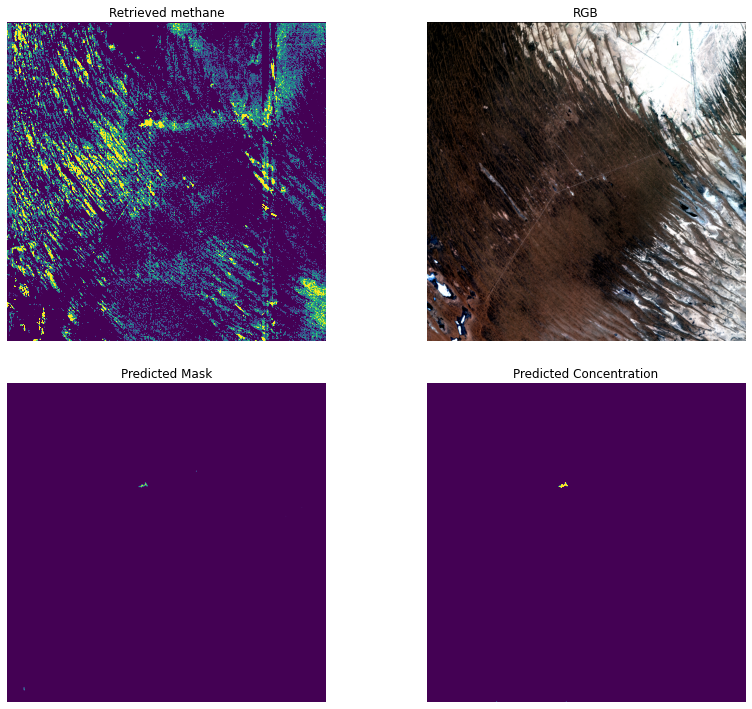

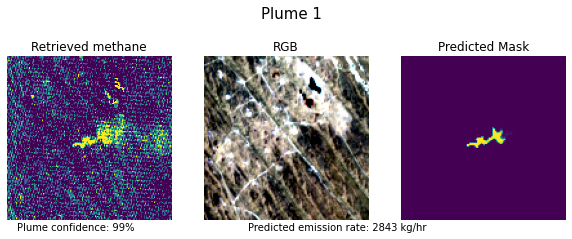

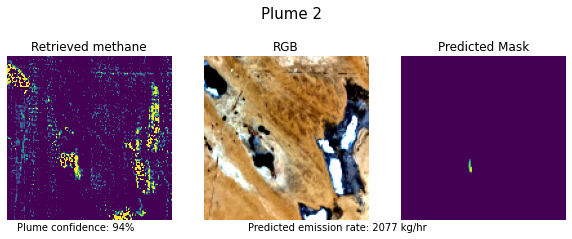

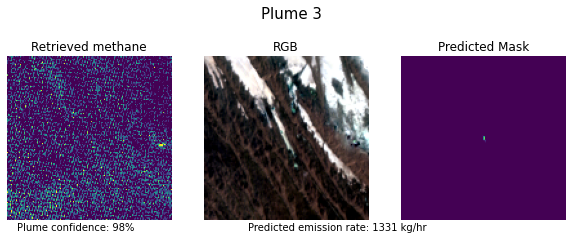

In [ ]:
def norm_image(imag):
    """normalise image so that max is 1 and min is 0"""
    miny=np.nanpercentile(imag,5)
    maxy=np.nanpercentile(imag,95)
    imag = (imag-miny)/(maxy-miny)
    return imag

alt_image=copy.deepcopy(orig_image)
alt_focused_input = copy.deepcopy(focused_input)
alt_image[:,:,0]=(alt_image[:,:,0]*6.308392e18)+4.7685366e+17
for i in range(1,4):alt_image[:,:,i]=norm_image(alt_image[:,:,i])

plt.figure(0, dpi=100)
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(alt_image[:,:,0],vmax=4e18,vmin=0)
axs[0, 0].set_axis_off() 
axs[0, 0].set_title('Retrieved methane')
axs[0, 1].imshow(alt_image[:,:,1:4])
axs[0, 1].set_axis_off() 
axs[0, 1].set_title('RGB')
axs[1, 0].imshow(mask_pred,vmax=1,vmin=0)
axs[1, 0].set_axis_off() 
axs[1, 0].set_title('Predicted Mask')
axs[1, 1].imshow(conc_pred*7e19,vmax=1e18)
axs[1, 1].set_axis_off() 
axs[1, 1].set_title('Predicted Concentration')
plt.tight_layout(pad=0.01, w_pad=-15, h_pad=0.1)
plt.gcf().set_size_inches(20, 10) #20, 10

plume_no=1
for plume in range(len(focused_input)):
  alt_focused_input[plume][:,:,0], alt_focused_input[plume][:,:,1],alt_focused_input[plume][:,:,2],alt_focused_input[plume][:,:,3] = (alt_focused_input[plume][:,:,0]*6.308392e18)+4.7685366e+17, norm_image(alt_focused_input[plume][:,:,1]),norm_image(alt_focused_input[plume][:,:,2]),norm_image(alt_focused_input[plume][:,:,3])
  em_rate=10000*focused_output[3][plume,0,0,0]
  binary_pred = focused_output[2][plume,0,0,0]

  if binary_pred>confidence_level_plume:
      plt.figure(plume+1)
      fig, axs = plt.subplots(1, 3)
      axs[0].imshow(alt_focused_input[plume][:,:,0],vmax=1e19,vmin=0)
      axs[0].set_axis_off() 
      axs[0].set_title('Retrieved methane')

      axs[1].imshow(alt_focused_input[plume][:,:,1:4])
      axs[1].set_axis_off() 
      axs[1].set_title('RGB')
      plt.text(-110,-30,'Plume '+str(plume_no),fontsize=15)
      axs[2].imshow(focused_output[0][plume,:,:,0],vmin=0,vmax=1)
      axs[2].set_axis_off() 
      axs[2].set_title('Predicted Mask')
      plt.text(-120,135,'Predicted emission rate: '+str(int(em_rate))+ ' kg/hr')
      plt.text(-300,135, 'Plume confidence: '+str(int(100*binary_pred))+'%')
      plt.gcf().set_size_inches(10, 5) #20, 10

      plume_no+=1
